In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Data loading and Cleaning
airing = pd.read_csv('/Users/zhanghaoyue/Downloads/airing.csv')
ads = pd.read_csv('/Users/zhanghaoyue/Downloads/ads.csv')
airing['message'] = airing['message'].replace('mix', 'mixed')
ads = ads[ads['air_count'] != 0]

In [37]:
airing.describe()

,id,wp_identifier,cycle,airtime
count,375350.000000,375350.000000,346249.0,375350.000000
mean,243678.989394,3997.479342,2016.0,32.490627
std,142753.578957,2715.888143,0.0,10.300366
min,1.000000,232.000000,2016.0,14.000000
25%,117888.250000,1184.000000,2016.0,30.000000
50%,228181.500000,4641.000000,2016.0,30.000000
75%,380614.750000,6603.000000,2016.0,30.000000
max,475694.000000,8404.000000,2016.0,300.000000


In [38]:
ads.describe()

,wp_identifier,cycle,air_count,reference_count,market_count
count,1400.000000,1321.0,1400.000000,1400.00000,1400.000000
mean,4055.952857,2016.0,268.107143,0.07500,2.902857
std,2539.242220,0.0,451.743189,0.30615,3.657103
min,232.000000,2016.0,1.000000,0.00000,1.000000
25%,1691.250000,2016.0,13.000000,0.00000,1.000000
50%,3999.000000,2016.0,135.500000,0.00000,1.000000
75%,6320.250000,2016.0,332.000000,0.00000,3.000000
max,8404.000000,2016.0,5084.000000,4.00000,23.000000


In [24]:
# Calculating Airtime
airing['start_time'] = pd.to_datetime(airing['start_time'])
airing['end_time'] = pd.to_datetime(airing['end_time'])
airing['airtime'] = (airing['end_time'] - airing['start_time']).dt.total_seconds()
airtime_avg = airing.groupby('wp_identifier')[['airtime']].agg(['mean', 'sum']).reset_index()
airtime_avg.columns = ['_'.join(col).strip('_') for col in airtime_avg.columns.to_flat_index()]
airtime_avg.sort_values(by='airtime_mean', ascending=False)

,wp_identifier,airtime_mean,airtime_sum
442,2257,300.000000,900.0
334,1665,236.000000,5428.0
687,3896,235.000000,1410.0
207,987,216.000000,4536.0
676,3758,195.000000,22425.0
...,...,...,...
378,1829,14.813725,1511.0
394,1951,14.724138,427.0
379,1830,14.500000,1566.0
365,1769,14.400000,216.0


In [25]:
# Combining Airtime and Reference Count
airtime_ref = pd.merge(airtime_avg, ads, how='left', on='wp_identifier')
airtime_ref[['wp_identifier', 'airtime_mean','airtime_sum', 'reference_count']]

,wp_identifier,airtime_mean,airtime_sum,reference_count
0,232,29.706814,61909.0,0
1,238,29.905089,21741.0,0
2,240,29.578338,43421.0,1
3,243,29.000000,29.0,0
4,244,15.000000,1305.0,0
...,...,...,...,...
1395,8360,31.434783,2169.0,0
1396,8361,60.425926,3263.0,0
1397,8364,30.000000,8280.0,0
1398,8403,30.183784,5584.0,0


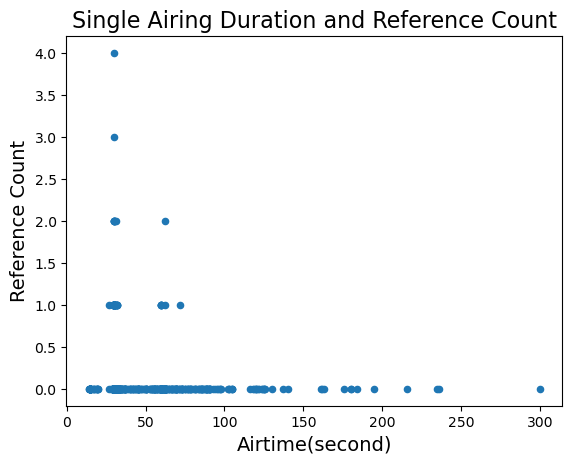

In [26]:
# Plot reference count & single ad duration
airtime_ref.plot(kind='scatter', x = 'airtime_mean', y = 'reference_count')
plt.xlabel('Airtime(second)' , fontsize = 14)
plt.ylabel('Reference Count', fontsize = 14)
plt.title('Single Airing Duration and Reference Count', fontsize=16)
plt.show()

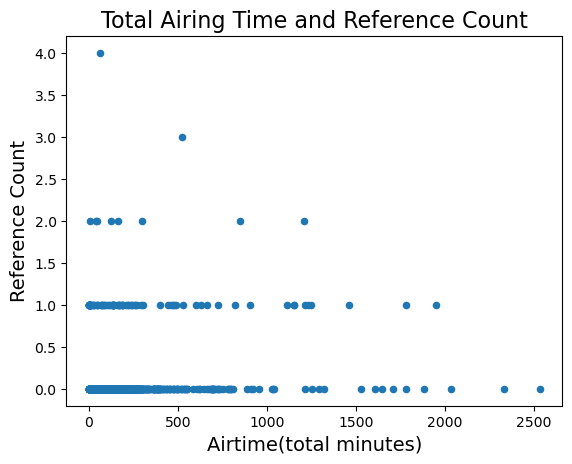

In [27]:
# Plot reference count & total airtime 
airtime_ref['airtime_sum'] = airtime_ref['airtime_sum'] / 60
airtime_ref.plot(kind='scatter', x = 'airtime_sum', y = 'reference_count')
plt.xlabel('Airtime(total minutes)', fontsize = 14)
plt.ylabel('Reference Count', fontsize =14)
plt.title('Total Airing Time and Reference Count', fontsize=16)
plt.show()

In [28]:
# Unpivot candidate column and compute coving locations for candidate
airing['cand_list'] = airing['candidates'].str.split(', ')
candidate_explode = airing.explode('cand_list', ignore_index=True)
candidate_loc = candidate_explode.groupby('cand_list')[['location']].nunique()
candidate_loc.sort_values(by='location', ascending=False)

,location
cand_list,
Hillary Clinton,25
Donald Trump,25
Marco Rubio,24
Ted Cruz,23
Bernie Sanders,23
...,...
Andy Biggs,1
Kumar Barve,1
Loretta Sanchez,1


In [29]:
# Unpivot Candidate tone and compute % of tone
candidate_tone = candidate_explode.groupby(['cand_list', 'message'])[['wp_identifier']].count().reset_index()
candidate_tone_pivot = candidate_tone.pivot(index='cand_list', columns='message', values='wp_identifier')
candidate_tone_pivot_perc = candidate_tone_pivot.div(candidate_tone_pivot.sum(axis=1), axis=0) * 100
candidate_tone_pivot_perc

message,con,mixed,pro,unknown
cand_list,,,,
Alan Grayson,NaN,100.000000,NaN,NaN
Andy Biggs,100.000000,NaN,NaN,NaN
Ann Kirkpatrick,9.683739,65.547159,24.769102,NaN
Anthony Brown,NaN,NaN,100.000000,NaN
Ben Carson,0.051046,NaN,48.034712,51.914242
...,...,...,...,...
Tim Kaine,100.000000,NaN,NaN,NaN
Todd Young,100.000000,NaN,NaN,NaN
Warren Davidson,NaN,24.216867,75.783133,NaN


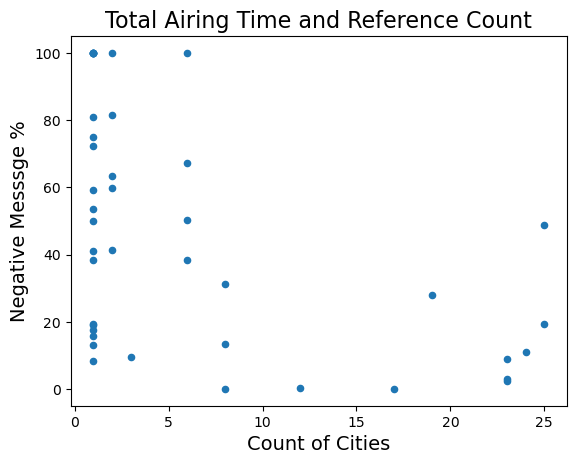

In [30]:
# Plot relationship between negative tone and covering locations
loc_tone = pd.merge(candidate_tone_pivot_perc, candidate_loc, on='cand_list', how='left')
loc_tone.plot(x='location', y='con', kind='scatter')
plt.xlabel('Count of Cities', fontsize = 14)
plt.ylabel('Negative Messsge %', fontsize =14)
plt.title('Total Airing Time and Reference Count', fontsize=16)
plt.show()

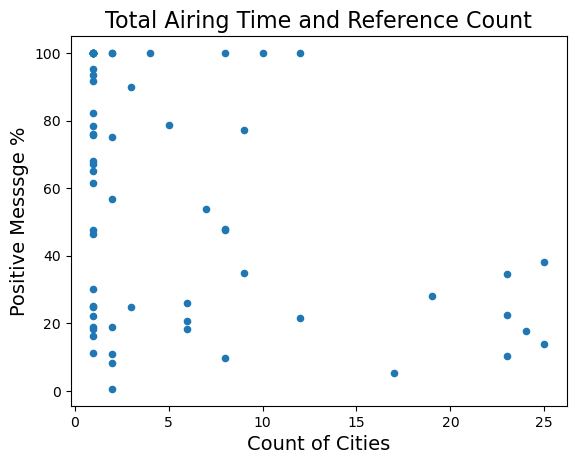

In [31]:
# Plot relationship between positive tone and covering locations
loc_tone.plot(x='location', y='pro', kind='scatter')
plt.xlabel('Count of Cities', fontsize = 14)
plt.ylabel('Positive Messsge %', fontsize =14)
plt.title('Total Airing Time and Reference Count', fontsize=16)
plt.show()

In [32]:
# unpivot subjects of Candidates and count subject frequency
candidate_explode['subjects'] = candidate_explode['subjects'].str.split(', ')
candidate_explode_contnet = candidate_explode.explode('subjects', ignore_index=True)
candidate_contnet = candidate_explode_contnet.groupby(['cand_list', 'subjects'])[['wp_identifier']].count().reset_index()
candidate_contnet.sort_values(by='wp_identifier', ascending=False)

,cand_list,subjects,wp_identifier
263,Donald Trump,Candidate Biography,46633
396,Hillary Clinton,Candidate Biography,29889
325,Donald Trump,Terrorism,21600
424,Hillary Clinton,Health Care,20584
308,Donald Trump,Military,19721
...,...,...,...
589,John Kasich,Immigration,1
102,Carson,Negative Campaigning,1
349,Evan Bayh,Jobs,1
863,Martin O'Malley,Immigration,1


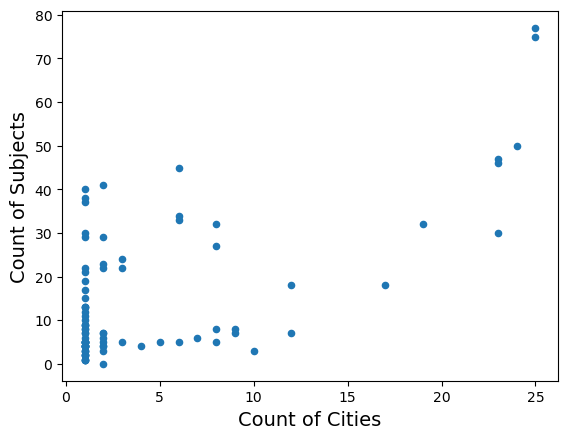

In [33]:
# Analysis between gepgraphic reach and subjects
loc_content = pd.merge(candidate_loc, candidate_contnet, on='cand_list', how='left')
loc_content_count = loc_content.groupby('cand_list').agg({
    'location': 'mean',       # Apply mean to 'location'
    'subjects': 'nunique'     # Apply unique count to 'subjects'
})
loc_content_count.plot(x='location', y='subjects', kind='scatter')
plt.xlabel('Count of Cities', fontsize = 14)
plt.ylabel('Count of Subjects', fontsize =14)
plt.show()

In [34]:
# Generating examples from two extreme
hillary_data = loc_content[loc_content['cand_list'] == 'Hillary Clinton'].nlargest(10, 'wp_identifier')
joy_data = loc_content[loc_content['cand_list'] == 'Roy Cooper'].nlargest(10, 'wp_identifier')

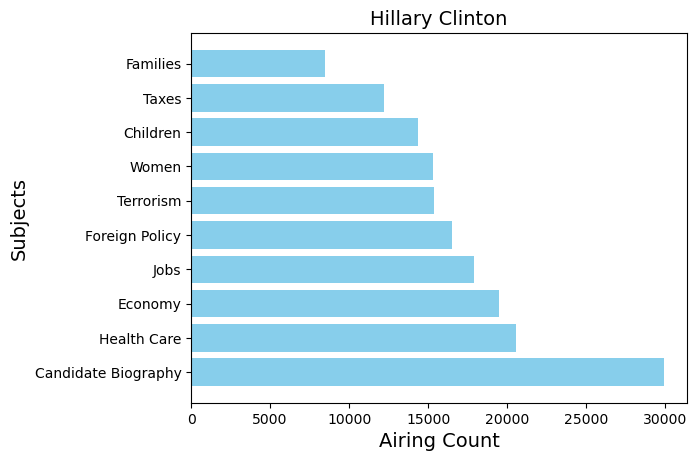

In [35]:
# plot top 10 subjects for Hillary Clinton
plt.barh(hillary_data['subjects'], hillary_data['wp_identifier'], color='skyblue')
plt.xlabel('Airing Count',fontsize = 14)
plt.ylabel('Subjects',fontsize = 14)
plt.title('Hillary Clinton',fontsize = 14)
plt.show()

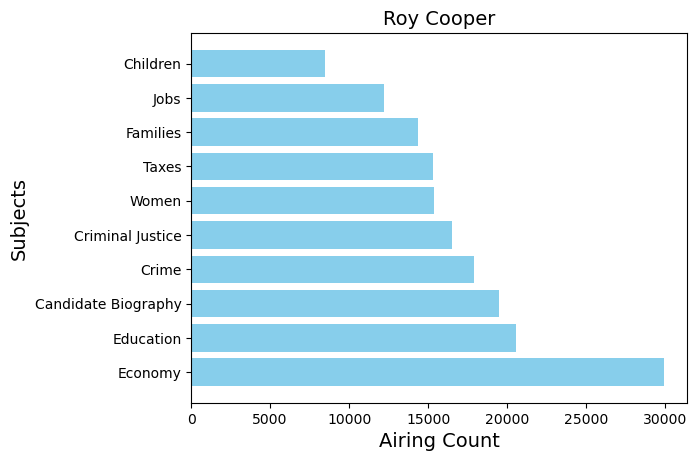

In [36]:
# plot top 10 subjects for Roy Cooper
plt.barh(joy_data['subjects'], hillary_data['wp_identifier'], color='skyblue')
plt.xlabel('Airing Count',fontsize = 14)
plt.ylabel('Subjects',fontsize = 14)
plt.title('Roy Cooper',fontsize = 14)
plt.show()